## Preprocessing

In [1]:
from nilearn import plotting
%matplotlib inline
import os
import json
from nipype.interfaces import fsl 
from nipype.interfaces import spm
from nipype.interfaces.spm import (Realign, SliceTiming, Coregister,  NewSegment,  Normalize12, Smooth)
from nipype.interfaces import matlab as mlab
from nipype.interfaces.io import SelectFiles, DataSink
import nipype.interfaces.utility as util 
from nipype.algorithms import rapidart as ra
from nipype.interfaces.utility import IdentityInterface, Function
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio
from nipype import DataGrabber, Workflow, Node

In [2]:
spm.SPMCommand.set_mlab_paths(paths=os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')), matlab_cmd='/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB -nodesktop -nosplash')

stty: 'standard input': Inappropriate ioctl for device


In [3]:
mlab.MatlabCommand.set_default_matlab_cmd("/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB  -nodesktop -nosplash")
mlab.MatlabCommand.set_default_paths(os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')))

In [4]:
# spm.SPMCommand().version

In [5]:
fsl.FSLCommand.set_default_output_type('NIFTI')

In [6]:
base_dir = os.path.join(os.environ['HOME'], 'spmbasics/data/')

In [7]:
experiment_dir = os.path.join(base_dir, 'output')
data_dir = os.path.abspath(os.path.join(base_dir, 'face_rep'))
output_dir = 'nipype'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['M03953']
# below info referred by datagrabber needs to be referred within infosource, selectfiles 
#info = dict(
#    func=[['RawEPI', 'subject_id', 5, ["_%04d" % i for i in range(6, 357)]]],
#    struct=[['Structural', 'subject_id', 7, '']])

# TR of functional images
TR = 2.
# Smoothing width used during preprocessing
fwhm = [8]

In [8]:
infosource = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

In [9]:
#file = '/home/matay/spmbasics/data/face_rep/Structural/sM03953_0007.img'

In [10]:
def save_as_nii(subject_id):
    import nibabel as nb
    import os
    img = nb.load(subject_id)
    nb.save(img, subject_id.replace('.img', '.nii'))
    nii_img = os.path.join(os.path.join(os.environ['HOME'], 'spmbasics/data/face_rep/Structural'), 'anat_img.nii')
    output_file = nb.save(img, nii_img)
    return nii_img

In [11]:
#save_as_nii(file)

In [12]:
#saveasnii = Node(Function(input_names = ['subject_id'], output_names = ['output'],
                        # function = save_as_nii), name = 'saveasnii')

In [13]:
anat_file = os.path.join('Structural', 'sM03953_0007.img')
func_file = os.path.join('RawEPI', 'sM03953_0005_*.img')

templates = {'struct':anat_file,
            'func':func_file}

selectfiles = Node(SelectFiles(templates,
                               base_directory=data_dir),
                   name="selectfiles")

In [14]:
merge = Node(interface=fsl.Merge(), name="merge")
merge.inputs.dimension = "t" 
merge.inputs.output_type = 'NIFTI'

In [15]:
realigner = Node(interface=Realign(), name='realign')
realigner.inputs.register_to_mean = True
realigner.inputs.fwhm = 5
realigner.inputs.interp = 2
realigner.inputs.quality = 0.9
realigner.inputs.separation = 4
realigner.inputs.wrap = [0, 0, 0]
realigner.inputs.write_which = [2, 1]
realigner.inputs.write_interp = 4 
realigner.inputs.write_wrap = [0, 0, 0]
realigner.inputs.write_mask = True
realigner.inputs.jobtype = 'estwrite'
realigner.inputs.out_prefix = 'r'

In [16]:
slicetiming = Node(interface=SliceTiming(), name = 'slicetiming')
slicetiming.inputs.num_slices = 24
slicetiming.inputs.time_repetition = 2.
slicetiming.inputs.time_acquisition = 1.92
slicetiming.inputs.slice_order = list(range(24,0,-1))
slicetiming.inputs.ref_slice = 12
slicetiming.inputs.out_prefix = 'a'

In [17]:
coregister = Node(Coregister(), name="coregister")
coregister.inputs.jobtype = 'estimate'
coregister.inputs.cost_function = 'nmi'
coregister.inputs.fwhm = [7.0, 7.0]
coregister.inputs.separation = [4.0, 2.0]
coregister.inputs.tolerance = [0.02, 0.02, 0.02, 0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001]
coregister.inputs.out_prefix = 'c'

In [18]:
tpm_path = os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/tpm/', 'TPM.nii'))

In [19]:
segment =  Node(NewSegment(), name="newsegment")
segment.inputs.affine_regularization = 'mni'
segment.inputs.channel_info = (0.001, 60, (False, True)) #save bias corrected map
tissue1 = ((tpm_path, 1), 1, (True, False), (False, False))
tissue2 = ((tpm_path, 2), 1, (True, False), (False, False))
tissue3 = ((tpm_path, 3), 2, (True, False), (False, False))
tissue4 = ((tpm_path, 4), 3, (True, False), (False, False))
tissue5 = ((tpm_path, 5), 4, (True, False), (False, False))
tissue6 = ((tpm_path, 6), 2, (False, False), (False, False))
segment.inputs.tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]
segment.inputs.warping_regularization = [0, 0.001, 0.5, 0.05, 0.2]
segment.inputs.sampling_distance = 3
segment.inputs.write_deformation_fields = [False, True] 

stty: 'standard input': Inappropriate ioctl for device


In [20]:
normalize = Node(Normalize12(), name="normalize") 
normalize.inputs.jobtype = 'write'
normalize.inputs.write_bounding_box =  [[-78, -112, -70], [78, 76, 85]]
normalize.inputs.write_voxel_sizes = [3, 3, 3]
normalize.inputs.write_interp = 4
normalize.inputs.out_prefix = 'w'

In [21]:
smooth = Node(Smooth(), name="smooth")
smooth.inputs.fwhm = [8, 8, 8]
smooth.inputs.data_type = 0
smooth.inputs.implicit_masking = False
smooth.inputs.out_prefix = 's'

In [22]:
art = Node(ra.ArtifactDetect(), name="art")
art.inputs.use_differences = [True, False] # successive motion, # intensity parameter
art.inputs.use_norm = True
art.inputs.norm_threshold = 1
art.inputs.zintensity_threshold = 3
art.inputs.mask_type = 'spm_global'
art.inputs.intersect_mask = True
art.inputs.bound_by_brainmask = True
art.inputs.parameter_source = 'SPM'
art.inputs.plot_type='png'

In [23]:
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

In [24]:
def get_vox_dims(volume):
    import nibabel as nb
    if isinstance(volume, list):
        volume = volume[0]
    nii = nb.load(volume)
    hdr = nii.header
    voxdims = hdr.get_zooms()
    return [float(voxdims[0]), float(voxdims[1]), float(voxdims[2])]

In [25]:
event_preproc = Workflow(name='nipype_event_preproc')
event_preproc.base_dir = os.path.join(experiment_dir, working_dir)

In [26]:
event_preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                 (selectfiles, realigner, [('func', 'in_files')]),
                 (selectfiles, datasink, [('func', 'event_preproc.@func'),
                                          ('struct', 'event_preproc.@struct')]),  
                 (realigner, datasink, [('realignment_parameters', 'event_preproc.@realignement_parameters'),
                                        ('realigned_files', 'event_preproc.@realigned_files'),
                                        ('mean_image', 'event_preproc.@mean_image')]),
                 (realigner, slicetiming, [('realigned_files', 'in_files')]),  
                 (slicetiming, datasink, [('timecorrected_files', 'event_preproc.@timecorrected_files')]),
                 (realigner, coregister, [('mean_image', 'target')]),
                 (selectfiles, coregister, [('struct', 'source')]), 
                 (coregister, datasink, [('coregistered_source', 'event_preproc.@coregisered_source')]),
                 (coregister, segment, [('coregistered_source', 'channel_files')]),
                 (segment, datasink, [('bias_corrected_images', 'event_preproc.@bias_corrected_images'),
                                      ('transformation_mat', 'event_preproc.@transformation_mat'),
                                      ('native_class_images', 'event_preproc.@native_class_images'),
                                      ('forward_deformation_field', 'event_preproc.@forward_deformation_field')]),
                 (segment, normalize, [('forward_deformation_field', 'deformation_file')]),
                 (slicetiming, normalize, [('timecorrected_files', 'apply_to_files')]), 
                 (normalize, datasink, [('normalized_files', 'event_preproc.@normalized_files')]),
                 (normalize, smooth, [('normalized_files', 'in_files')]),
                 (smooth, datasink, [('smoothed_files', 'event_preproc.@smoothed_files')]),
                 (realigner, art, [('realignment_parameters', 'realignment_parameters')]),
                 (normalize, art, [('normalized_files', 'realigned_files')]),
                 (art, datasink, [('outlier_files', 'event_preproc.@outlier_files'),
                                  ('plot_files', 'event_preproc.@plot_files')])
])

In [27]:
event_preproc.write_graph(graph2use='colored', format='png', dotfilename='colored_event.dot', simple_form=True)

240527-18:10:00,477 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/nipype_event_preproc/colored_event.png (graph2use=colored, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/nipype_event_preproc/colored_event.png'

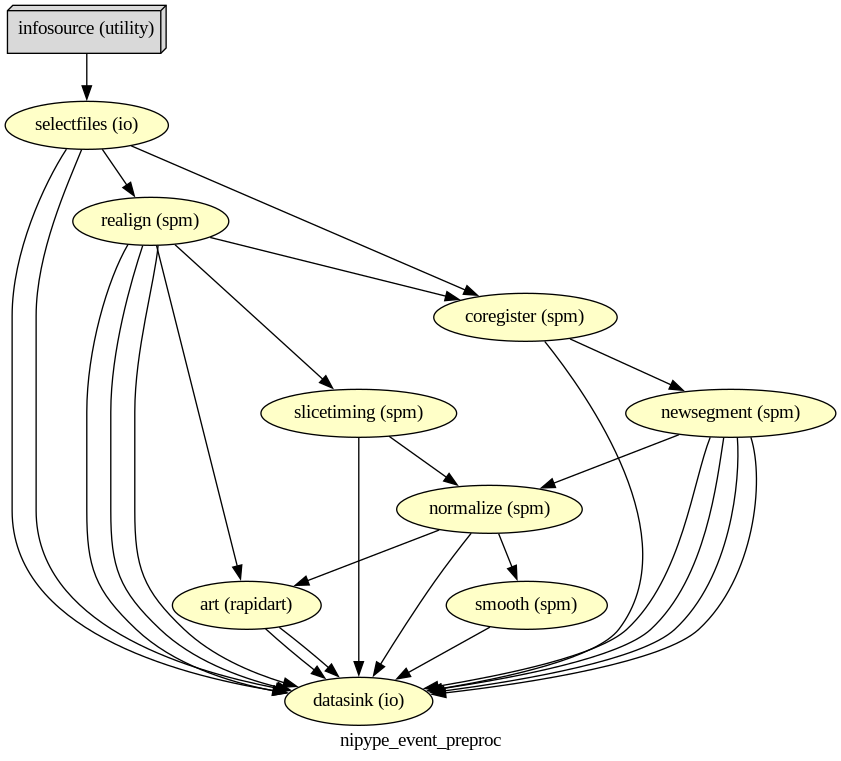

In [28]:
# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(event_preproc.base_dir, 'nipype_event_preproc', 'colored_event.png'))

In [29]:
event_preproc.write_graph(graph2use='flat', format='png', simple_form=True, dotfilename='flat_event.dot')

240527-18:10:05,333 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/nipype_event_preproc/flat_event.png (graph2use=flat, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/nipype_event_preproc/flat_event.png'

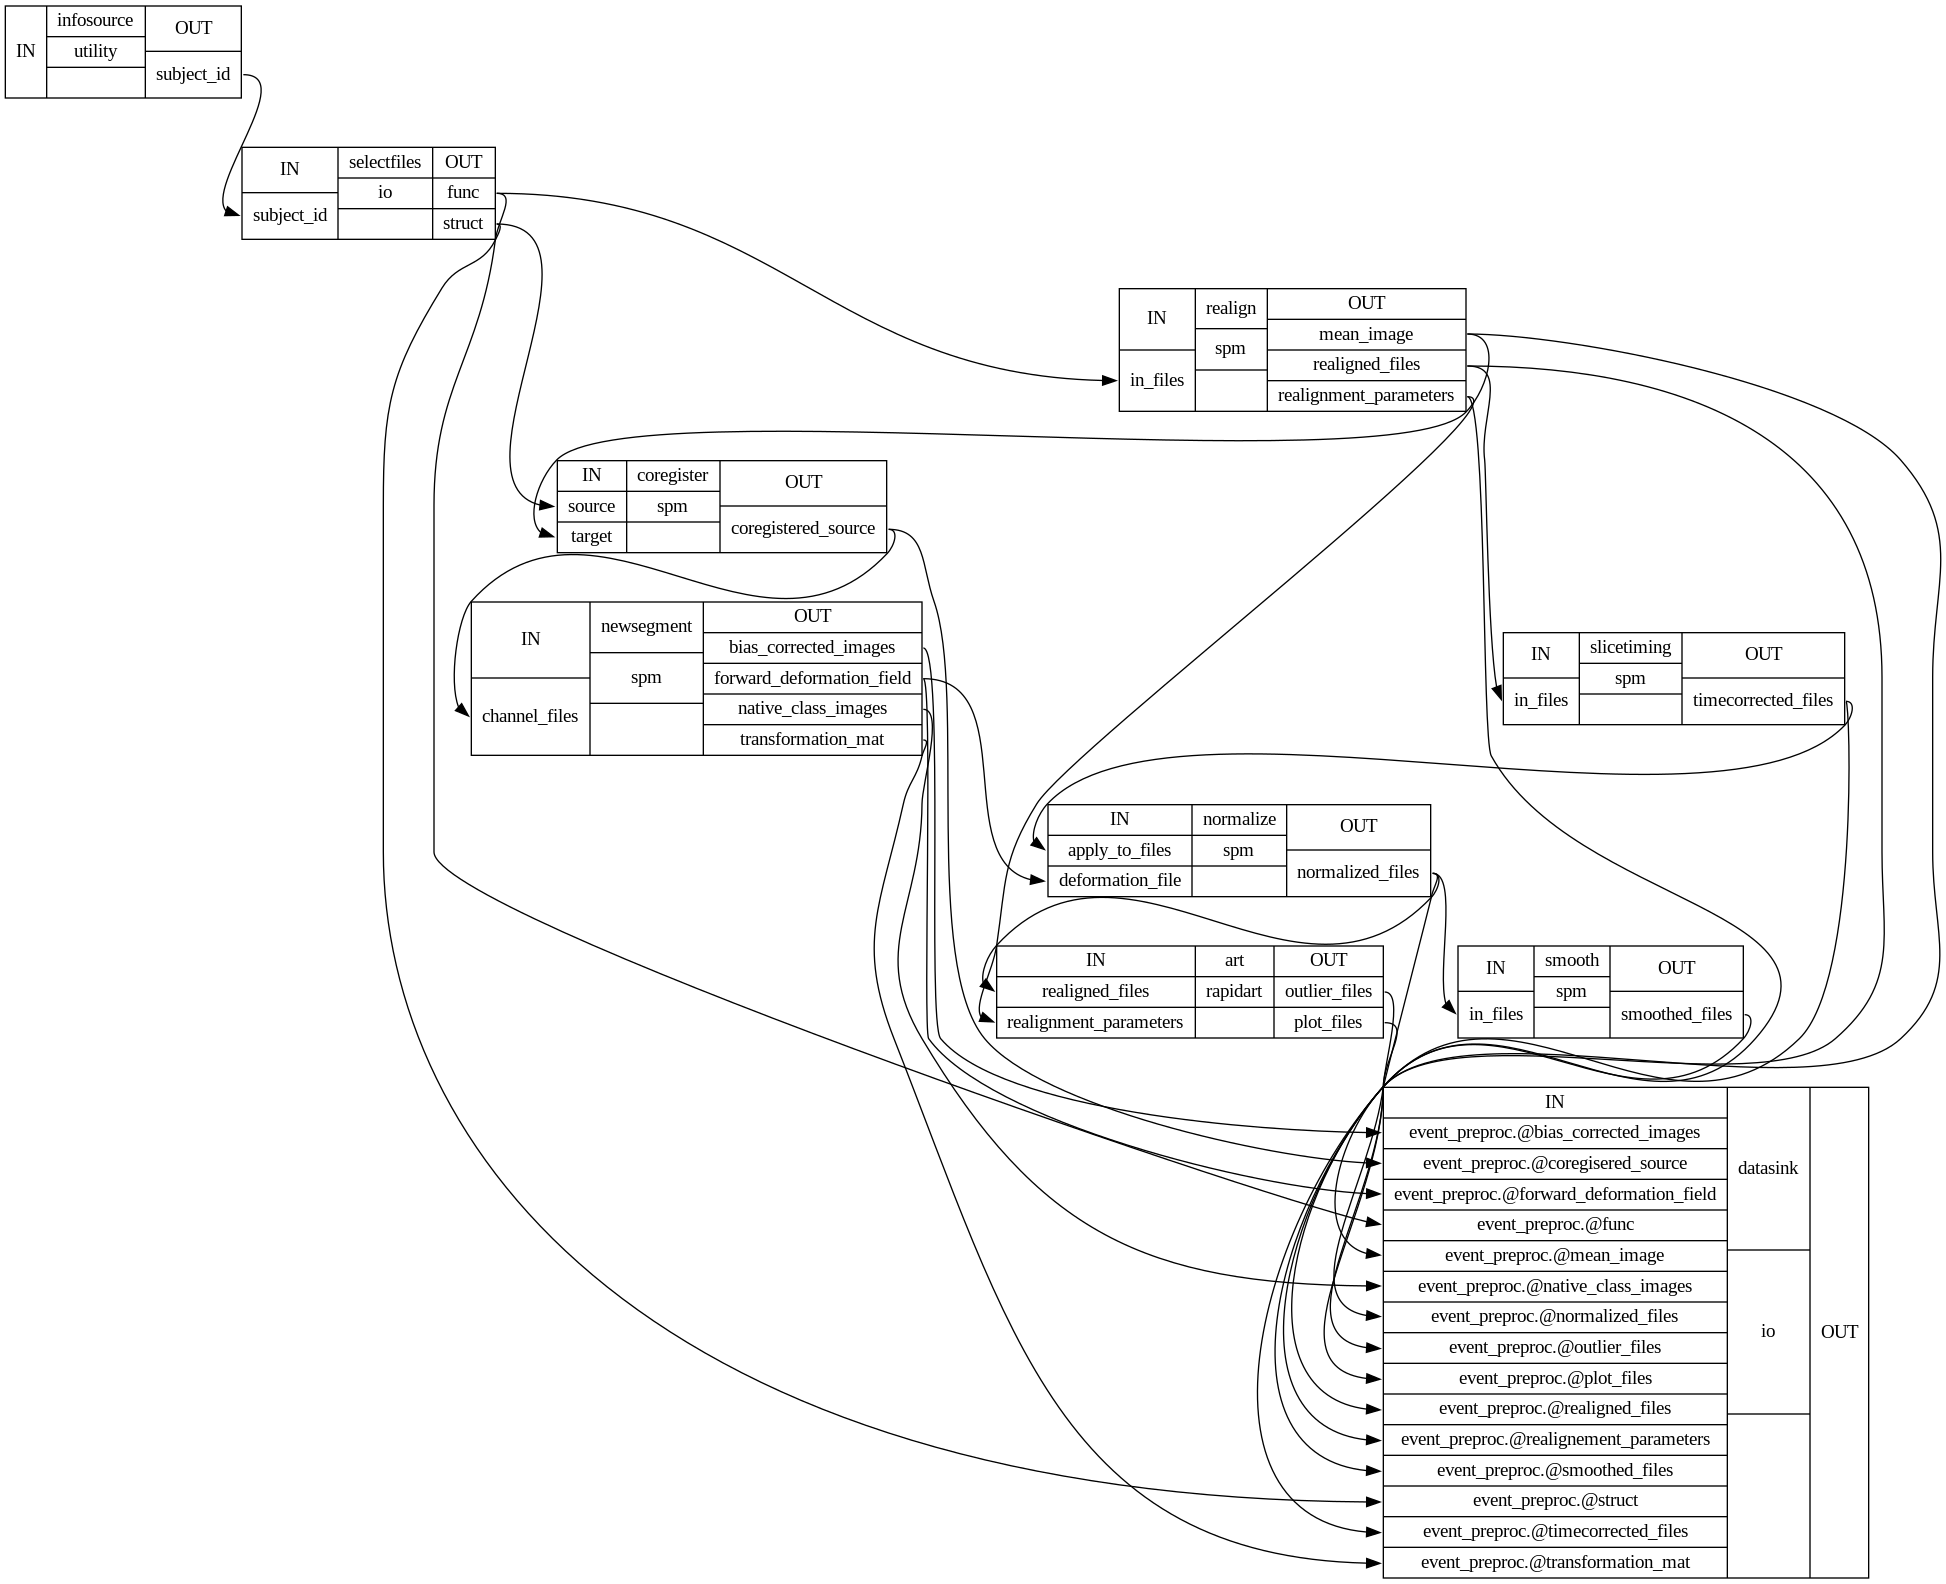

In [30]:
# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(event_preproc.base_dir, 'nipype_event_preproc', 'flat_event_detailed.png'))

In [ ]:
event_preproc.run('MultiProc', plugin_args={'n_procs': 4})

240527-18:10:27,75 nipype.workflow INFO:
	 Workflow nipype_event_preproc settings: ['check', 'execution', 'logging', 'monitoring']
240527-18:10:27,81 nipype.workflow INFO:
	 Running in parallel.
240527-18:10:27,83 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240527-18:10:27,155 nipype.workflow INFO:
	 [Node] Setting-up "nipype_event_preproc.selectfiles" in "/home/matay/spmbasics/data/output/workingdir/nipype_event_preproc/_subject_id_M03953/selectfiles".
240527-18:10:27,159 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
240527-18:10:27,165 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.003424s.
240527-18:10:29,86 nipype.workflow INFO:
	 [Job 0] Completed (nipype_event_preproc.selectfiles).
240527-18:10:29,90 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240527-18:10:

stty: 'standard input': Inappropriate ioctl for device
